In [24]:
import pypsa, os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
plt.rc("figure", figsize=(10, 8))
import matplotlib as mpl
to_rgba = mpl.colors.colorConverter.to_rgba

In [25]:
from vresutils import Dict
from snakemake.rules import expand
import yaml
snakemake = Dict()
snakemake.wildcards = Dict(#cost=#'IRP2016-Apr2016',
                            costs='za_original',
                            regions='27-supply',
                            resarea='redz',
                            ll='copt',
                            opts='LC',
                            attr='p_nom')

snakemake.input = Dict(network='../results/version-0.6/networks/solved_{costs}_{regions}_{resarea}_l{ll}_{opts}.nc'.format(**snakemake.wildcards),
                        supply_regions='../data/supply_regions/supply_regions_{regions}.shp'.format(**snakemake.wildcards),
                        resarea = "../data/bundle/REDZ_DEA_Unpublished_Draft_2015")
snakemake.output = (expand('../results/plots/{costs}_{regions}_{resarea}_l{ll}_{opts}_{attr}.pdf',
                            **snakemake.wildcards) +
                    expand('../results/plots/{costs}_{regions}_{resarea}_l{ll}_{opts}_{attr}_ext.pdf',
                            **snakemake.wildcards))
snakemake.params = Dict(ext=['png'])
# with open('../config.yaml') as f:
#     snakemake.config = yaml.load(f)


import yaml
with open("../config.yaml", 'r') as stream:
    try:
        snakemake.config=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

tech_costs = "../data/costs.xlsx"

In [26]:
n=pypsa.Network(snakemake.input.network)
n.generators=n.generators[n.generators.carrier!='load_shedding']

INFO:pypsa.io:Imported network solved_za_original_27-supply_redz_lcopt_LC.nc has buses, carriers, generators, lines, loads, storage_units


In [27]:
opts = snakemake.config['plotting']
line_colors = {'cur': "purple",
               'exp': to_rgba("red", 0.7)}
tech_colors = opts['tech_colors']

In [28]:
bus_sizes = pd.concat(
    (
        n.generators.query('carrier != "Load"')
        .groupby(["bus", "carrier"])
        .p_nom_opt.sum(),
        n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum(),
    )
)
line_widths_exp = n.lines.s_nom_opt
line_widths_cur = n.lines.s_nom_min
link_widths_exp = n.links.p_nom_opt
link_widths_cur = n.links.p_nom_min

In [29]:
attribute="p_nom"
linewidth_factor = opts["map"][attribute]["linewidth_factor"]
bus_size_factor = opts["map"][attribute]["bus_size_factor"]
flow = pd.Series(10, index=n.branches().index)

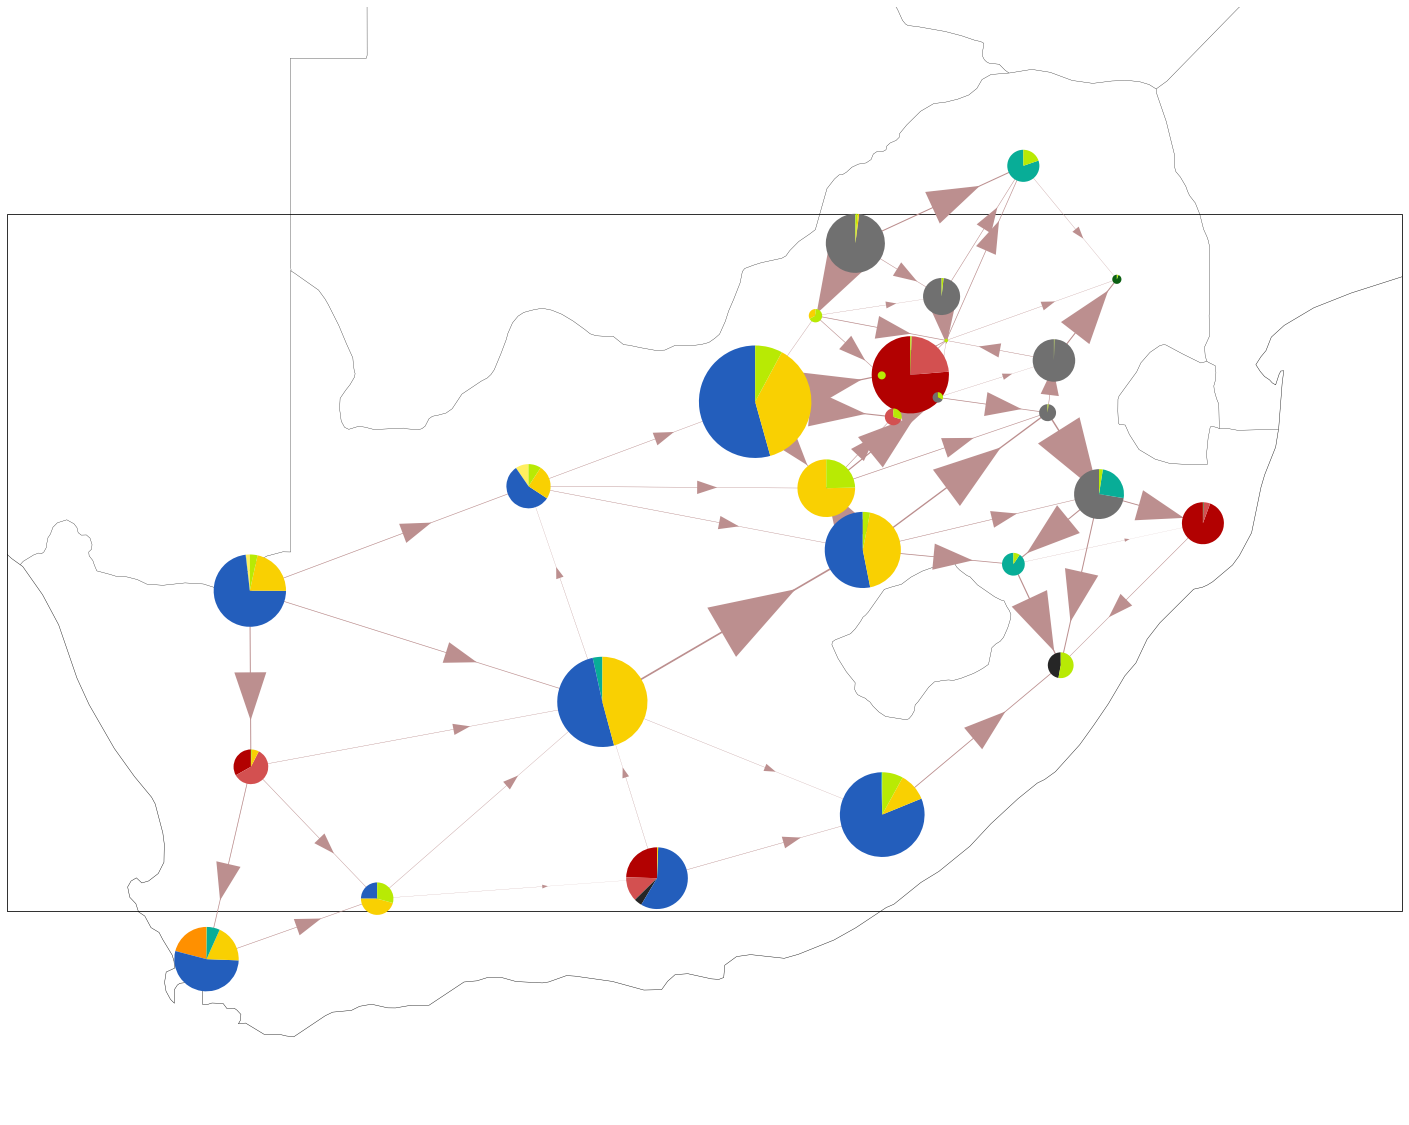

In [30]:
fig, ax = plt.subplots(
    figsize=[25,25], subplot_kw={"projection": ccrs.PlateCarree()}
)

n.plot(
    bus_sizes=bus_sizes / bus_size_factor,
    bus_colors=tech_colors,
    margin=0.2,
    flow="mean",
    line_widths=0.015,
    link_widths=1,
)
plt.show()

In [31]:
n.carriers.color

Carrier
coal       #707070
nuclear    #ff9000
PHS        #08ad97
hydro      #08ad97
CSP        #ffef60
biomass    #0c6013
diesel     #262626
gas        #d35050
CCGT       #b20101
OCGT       #d35050
battery    #b8ea04
Load              
Name: color, dtype: object

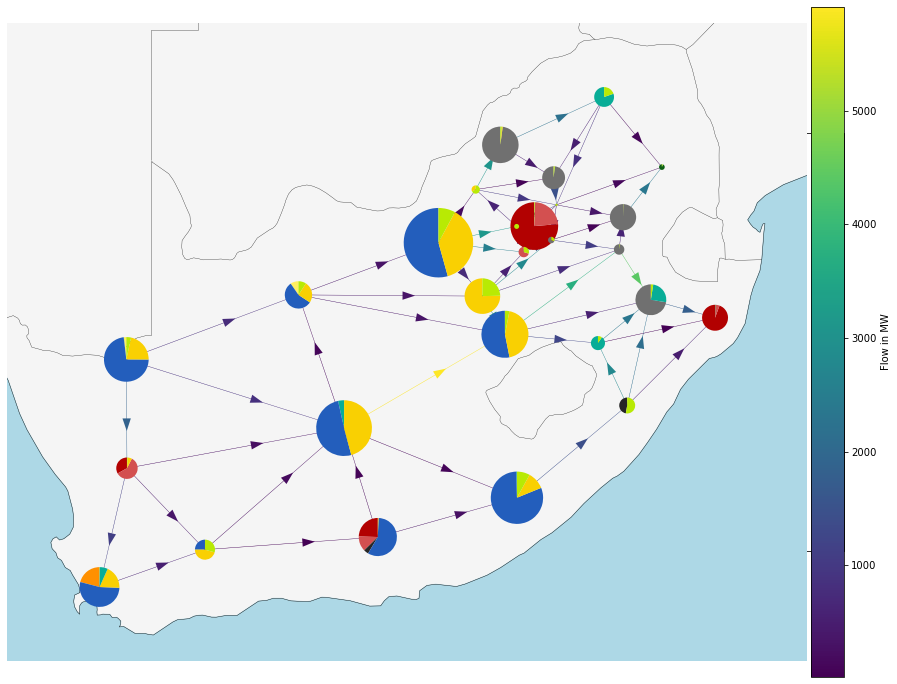

In [32]:
# Pandas series with MultiIndex
# links are not displayed for prettier output ('link_widths=0')
fig, ax = plt.subplots(
    figsize=[15,15], subplot_kw={"projection": ccrs.PlateCarree()}
)

collection = n.plot(
    bus_sizes=bus_sizes / bus_size_factor,
    bus_colors=tech_colors,
    margin=0.15,
    flow=flow,
    line_widths=0.5,
    link_widths=0,
    #projection=ccrs.EqualEarth(),
    color_geomap=True,
    line_colors=n.lines_t.p0.mean().abs(),
)

plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

In [33]:
n.generators

,bus,carrier,build_year,lifetime,p_nom,p_nom_extendable,ramp_limit_up,ramp_limit_down,marginal_cost,capital_cost,...,sign,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Kendal,HIGHVELD NORTH,coal,2040,3.0,3840.0,False,0.028125,0.028125,275.616262,5.940000e+05,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
Kusile,WARMBAD,coal,2040,11.0,2880.0,False,0.150000,0.150000,239.946081,4.700000e+06,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
MajubaDry,NEWCASTLE,coal,2040,8.0,1833.0,False,0.055646,0.055646,313.225393,5.940000e+05,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
MajubaWet,NEWCASTLE,coal,2040,11.0,2010.0,False,0.056716,0.056716,313.402204,5.940000e+05,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
Matimba,WATERBERG,coal,2040,1.0,3690.0,False,0.048780,0.048780,189.865811,5.940000e+05,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PORT ELIZABETH OCGT_2040,PORT ELIZABETH,OCGT,2040,30.0,0.0,True,NaN,NaN,1744.344920,8.894466e+05,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
JOHANNESBURG coal_2040,JOHANNESBURG,coal,2040,30.0,0.0,True,NaN,NaN,371.901440,4.072125e+06,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
WATERBERG coal_2040,WATERBERG,coal,2040,30.0,0.0,True,NaN,NaN,371.900983,4.072125e+06,...,1.0,False,0.0,0.0,0,0,1,0,1.0,1.0
